In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!wget https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip

--2026-02-11 04:30:32--  https://bitbucket.org/ishaanjav/code-and-deploy-custom-tensorflow-lite-model/raw/a4febbfee178324b2083e322cdead7465d6fdf95/fruits.zip
Resolving bitbucket.org (bitbucket.org)... 104.192.142.26, 104.192.142.25, 104.192.142.24, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.142.26|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2026-02-11 04:30:32 ERROR 404: Not Found.



In [7]:
!unzip fruits.zip

unzip:  cannot find or open fruits.zip, fruits.zip.zip or fruits.zip.ZIP.


In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.19.0'

In [ ]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/validation",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "fruits/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 460 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Found 130 files belonging to 3 classes.


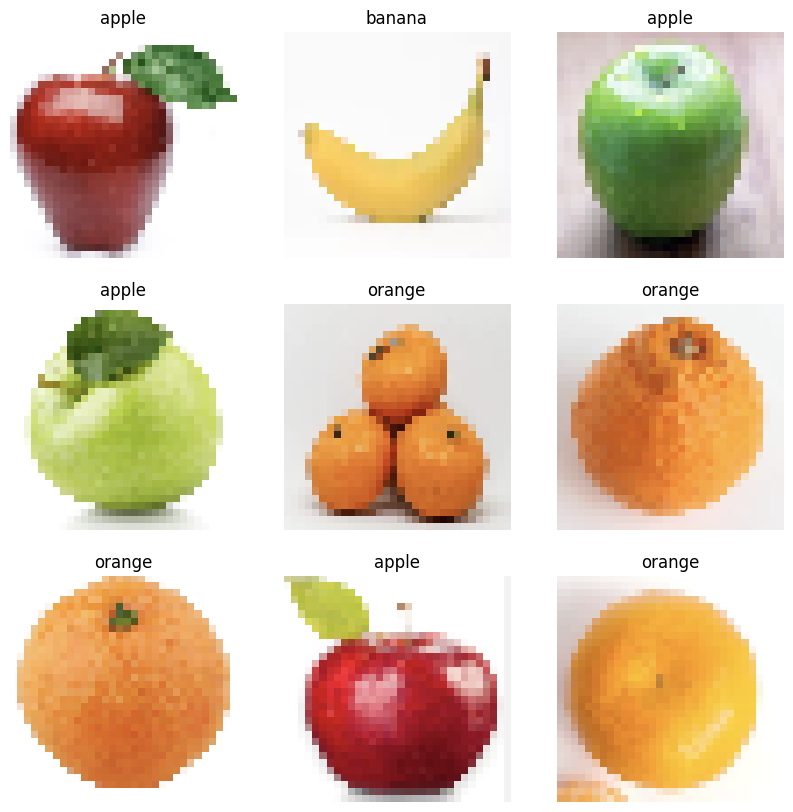

In [ ]:
class_names = ["apple", "banana", "orange"]
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(64, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(128, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="softmax"),
     tf.keras.layers.Dense(3)
    ]
)

In [ ]:
model.compile(
    optimizer="rmsprop",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 20
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.3578 - loss: 1.0982 - val_accuracy: 0.5606 - val_loss: 1.0959
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.4972 - loss: 1.0879 - val_accuracy: 0.5303 - val_loss: 1.0203
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5397 - loss: 1.0308 - val_accuracy: 0.6061 - val_loss: 0.9738
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.6190 - loss: 0.9789 - val_accuracy: 0.5152 - val_loss: 0.9603
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.6768 - loss: 0.9420 - val_accuracy: 0.7273 - val_loss: 0.9252
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7855 - loss: 0.9038 - val_accuracy: 0.6515 - val_loss: 0.9239
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8185 - loss: 0.8709 - val_accuracy: 0.8788 - val_loss: 0.8242
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.8045 - loss: 0.8582 - val_accuracy: 0.8636 -

In [ ]:
model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.9338 - loss: 0.5920


[0.5669541358947754, 0.9538461565971375]

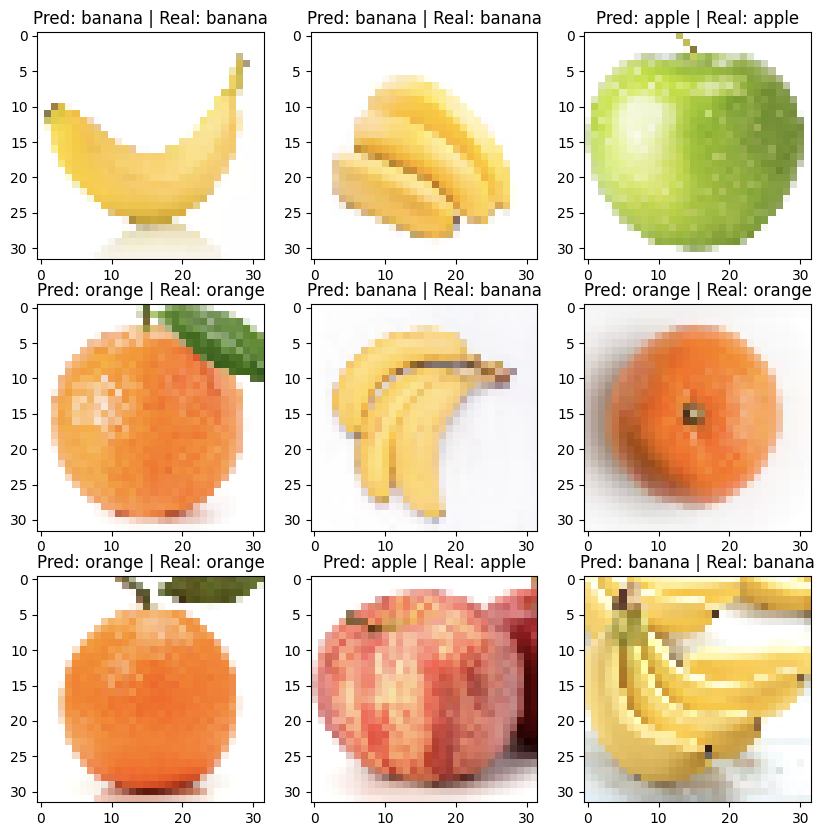

In [ ]:
import numpy

plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  classifications = model(images)
  # print(classifications)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = numpy.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp3toubpb1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138024249659792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024249664016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024249664208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024249665168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024249664784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024249665744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024249664592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024249666704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024249666128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138024249667664: TensorSpec(shape=(), dtype=tf.resource, name=None)
